# Homework 2.0: 單光子電腦斷層掃描的多類別分類
TODO
1. 實作SwinTransformer
2. 將設定的參數放進SwinTransformer

kaggle rule:
1. 不得使用兩隻以上的帳號繳交 submission檔案 (可參加但不可丟答案)
2. team的名稱記得一定要改成學號

## Import Packages

In [62]:
# torchsummary可以讓模型視覺化，以及匯出模型每層的詳細數量和每層的比例。
# !pip install torchsummary

In [63]:
import pydicom
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

## Configuration

In [64]:
class config:
    
    root = "./hwk02_data"
    batch_size = 16
    lr = 1e-4
    epochs = 100
    weight_decay = 1e-3
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 3
    
print('device:', config.device)

device: cuda


In [65]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    # 作用是啟用 batch normalization 和 dropout。
    # 保證 BN 層能夠用到每個 batch 資料的平均值和變異數。對於 Dropout 是隨機取一部分網路連線來訓練更新參數。
    model.train() 
    
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, ages, genders, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        ages = ages.to(device = device, dtype = torch.float)
        genders = genders.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        # Pytorch 中的分類損失函數（如 CrossEntropyLoss）期望 label 為 0 開始的整數。
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        scheduler.step() #switch place

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)
    # scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass


def validation(model, valid_loader, criterion, device):
    # 確保 BN 層能夠用全部訓練資料的平均值和變異數，即驗證過程中要保證 BN 層的平均值和變異數不變。對於 Dropout 是利用了所有網路連接，即不進行隨機捨棄神經元。
    # pytorch 會自動把 BN 和 DropOut 固定住，不會取平均，而是用訓練好的數值。
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    # TODO_2: 請將空白處填起來讓程式能夠運作。

    # 這邊禁用 PyTorch 梯度的自動計算，因為在 validation 階段我們不需要更新 model 的權重，因此不需要進行反向傳播(backpropagation)和梯度計算。
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            # Move data to the device (GPU or CPU)
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            # Forward pass: compute logits
            logits = model(images, ages, genders)
            
            # Adjust labels: converting from [1,2,3] to [0,1,2] as expected by CrossEntropyLoss
            labels = torch.sub(labels, 1)
            
            # Compute loss
            loss = criterion(logits, labels)

            # Accumulate validation loss
            valid_loss += loss.item()

            # Get predictions: select the index with the highest logit
            preds = torch.argmax(logits, dim=1)

            # Append predictions and ground truths for evaluation
            predictions.append(preds)
            ground_truths.append(labels)

        # Average validation loss over the entire dataset
        valid_loss /= len(valid_loader)

        # Concatenate all predictions and ground truths from different batches
        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)

        # Calculate validation accuracy, F1 score, and misclassification rate
        valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
        
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass


def printTrainresult(history, eps):
    train_loss=history["train"]["loss"][eps]
    train_acc=history["train"]["acc"][eps]
    train_f1=history["train"]["f1"][eps]
    train_misclass=history["train"]["misclass"][eps]
    valid_loss=history["valid"]["loss"][eps]
    valid_acc=history["valid"]["acc"][eps]
    valid_f1=history["valid"]["f1"][eps]
    valid_misclass=history["valid"]["misclass"][eps]
    
    # Plot loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    # Plot accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Accuracy')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    # Plot F1 score curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1 Score')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

    # Plot misclassification rate curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training Misclassification')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation Misclassification')
    plt.xlabel('Epoch')
    plt.ylabel('Misclassification Rate (%)')
    plt.legend()
    plt.title('Training and Validation Misclassification Rate')
    plt.show()
    
    print("BatchSize: ",config.batch_size," / LR: ",config.lr," / WeightDecay: ",config.weight_decay," / Seed: ",config.seed)
    print(f'Best result: Epoch{eps+1},\
        \nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% |\
        \nValid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}%')


In [66]:
class ParkinsonsDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, mode = None, transforms = None): # 將所有資料提出
        self.df = df
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, x): # 找出指定的資料
        
        age = torch.tensor(self.df.iloc[x, 1]) # 年齡
        gender = torch.tensor(self.df.iloc[x, 2]) # 性別
        index = torch.tensor(self.df.iloc[x, 4]) # 起始張數
        
        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :]
        
        if self.mode == "train":
            label = torch.tensor(self.df.iloc[x, 5]) # 標籤
            if self.transforms: image = self.transforms(image)

            return image, age, gender, label
        
        
        # TODO_3: 寫出當 mode = valid、test 的 getitem()
        
        
        elif self.mode == "valid":
            # Extract label for validation
            label = torch.tensor(self.df.iloc[x, 5], dtype=torch.long)  # Label for validation
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label

        elif self.mode == "test":
            # In test mode, there is no label to return
            if self.transforms: image = self.transforms(image)
            return image, age, gender

## Redefined VIT

In [67]:
class Normalization(object):
    
    def __call__(self, image): # 定義有image之後要進行的資料處理
        changed_image = (image - image.min())/(image.max() - image.min())
        return changed_image

def build_transform_ViT(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []
    # if is_train:
    #     t.append(v2.Grayscale(num_output_channels=1))  # Convert to grayscale
    #     t.append(v2.CenterCrop(size=(56, 56)))
    #     t.append(Normalization())
    #     return v2.Compose(t)
    t.append(v2.Grayscale(num_output_channels=1))  # Convert to grayscale (1 channel)
    t.append(v2.CenterCrop(size=(56, 56)))      # Crop to 56x56
    t.append(Normalization())
    return v2.Compose(t)

In [68]:
from timm.models.vision_transformer import VisionTransformer, PatchEmbed

class VisionTransformerCustom(nn.Module):
    def __init__(self, num_classes):
        super(VisionTransformerCustom, self).__init__()
        
        self.model = VisionTransformer(
            img_size=56,                # 影像大小
            patch_size=8,               # 一個 patch 大小
            in_chans=1,                 # input channels 大小
            embed_dim=96,               #  patch 經過展平再 linear 的維度
            embed_layer=PatchEmbed,     # 使用 PatchEmbed 完成上述的動作
            norm_layer=nn.LayerNorm,    # 使用 LayerNorm 來 norm
            depth=12,                   # 使用 12個 Blocks(Encoders)
            num_classes=num_classes     # 輸出的維度
        )
        
        self.model.head = nn.Identity() # 將最後的分類弄成 Identity()

        self.classifier = nn.Sequential(
            nn.Linear(96 + 2, num_classes)  # 把 age, gender 放進其中
        )
        

    def forward(self, x, age, gender):
        x = self.model(x)
        x = torch.cat([x, age.view(-1, 1), gender.view(-1, 1)], dim = 1)
        x = self.classifier(x)
        return x

In [69]:
#TODO_1: 設計自己的 SwinTransformer
#參考網站: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/swin_transformer.py
from timm.models.swin_transformer import SwinTransformer, PatchEmbed

class SwinTransformerCustom(nn.Module):
    def __init__(self, num_classes):
        super(SwinTransformerCustom, self).__init__()

        self.model = SwinTransformer(
            img_size=56,
            patch_size=4,
            in_chans=1,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            mlp_ratio=4.0,
            norm_layer=nn.LayerNorm,
            num_classes=num_classes
        )

        self.model.head.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(768 + 2, num_classes)  # 把 age, gender 放進其中
        )
        

    def forward(self, x, age, gender):
        x = self.model(x)
        x = torch.cat([x, age.view(-1, 1), gender.view(-1, 1)], dim=1)
        x = self.classifier(x)
        return x

In [70]:
#TODO_2: 將設定的參數放進SwinTransformer
model = SwinTransformer(
    img_size=56,                   # Image size
    patch_size=4,                  # Patch size
    in_chans=3,                    # Number of input channels (e.g., RGB images)
    embed_dim=96,                  # Embedding dimension
    depths=[2, 2, 6, 2],           # Depth of each stage
    num_heads=[3, 6, 12, 24],      # Number of heads in each stage
    window_size=7,                 # Window size
    mlp_ratio=4.0,                 # Ratio for MLP hidden dimension
    norm_layer=nn.LayerNorm,       # Normalization layer
    num_classes=config.num_classes  # Number of output classes
)

model.to(config.device)
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

# Note

Initializing Vision Transformer model...
Epoch[1/100], Train Loss: 2.9394, Train Acc: 25.89%, Train F1: 13.71% | Valid Loss: 2.4709, Valid Acc: 30.61%, Valid F1: 15.62%, Valid Misclass: 69.39% | LR: 0.000004
Epoch[2/100], Train Loss: 2.1558, Train Acc: 25.00%, Train F1: 14.31% | Valid Loss: 1.7382, Valid Acc: 30.61%, Valid F1: 19.63%, Valid Misclass: 69.39% | LR: 0.000005
Epoch[3/100], Train Loss: 1.6571, Train Acc: 33.04%, Train F1: 25.41% | Valid Loss: 1.3572, Valid Acc: 44.90%, Valid F1: 33.46%, Valid Misclass: 55.10% | LR: 0.000006
Epoch[4/100], Train Loss: 1.4504, Train Acc: 44.64%, Train F1: 30.95% | Valid Loss: 1.1957, Valid Acc: 44.90%, Valid F1: 30.21%, Valid Misclass: 55.10% | LR: 0.000008
Epoch[5/100], Train Loss: 1.3017, Train Acc: 44.64%, Train F1: 26.65% | Valid Loss: 1.1397, Valid Acc: 44.90%, Valid F1: 32.25%, Valid Misclass: 55.10% | LR: 0.000010
Epoch[6/100], Train Loss: 1.2004, Train Acc: 33.93%, Train F1: 25.21% | Valid Loss: 1.1781, Valid Acc: 40.82%, Valid F1: 35.

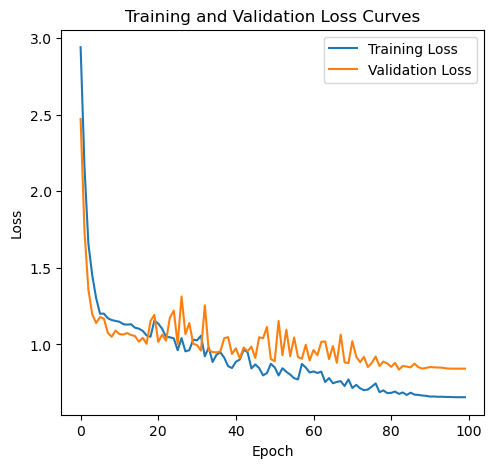

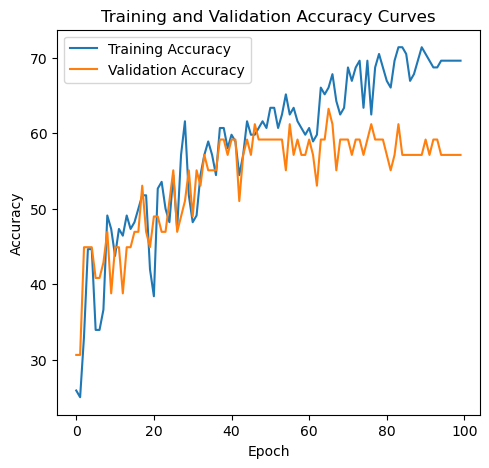

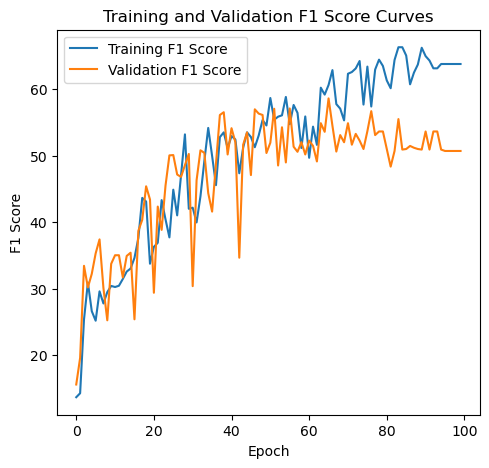

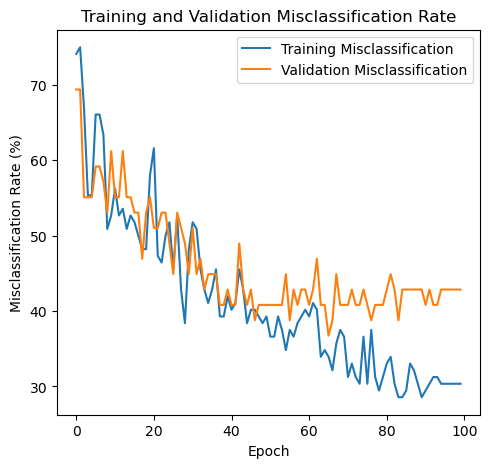

BatchSize:  16  / LR:  0.0001  / WeightDecay:  0.001  / Seed:  42
Best result: Epoch83,        
Train Loss: 0.6770, Train Acc: 69.64%, Train F1: 64.40% |        
Valid Loss: 0.8356, Valid Acc: 57.14%, Valid F1: 50.72%, Valid Misclass: 42.86%


In [71]:
def main():
    # Set seed for reproducibility
    seed_everything(config.seed)
    
    # Load the training data
    train_dataOrg = pd.read_csv(os.path.join(config.root, 'train.csv'))

    # Split the dataset into training and validation sets (70% train, 30% validation)
    train_data, val_data = train_test_split(train_dataOrg, train_size=0.7, test_size=0.3, random_state=config.seed)
    
    # Use the Vision Transformer transformations for ViT model
    train_dataset = ParkinsonsDataset(train_data, transforms=build_transform_ViT(True), mode="train")
    val_dataset = ParkinsonsDataset(val_data, transforms=build_transform_ViT(False), mode="valid")
    
    # DataLoader for training and validation sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    

    # Initialize the Vision Transformer model
    print("Initializing Vision Transformer model...")
    model = VisionTransformerCustom(num_classes=config.num_classes)  # Initialize VisionTransformerCustom

    # Move the model to the appropriate device
    model.to(config.device)

    # Define the loss function (CrossEntropy for classification)
    criterion = nn.CrossEntropyLoss().to(config.device)

    # Optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        epochs=config.epochs,
        steps_per_epoch=len(train_loader),
        max_lr=config.lr,
        anneal_strategy='cos'
    )

    # Metrics tracking best validation loss
    best_val_loss = float("inf")
    history = {
        "train": {"loss": [], "acc": [], "f1": [], "misclass": []},
        "valid": {"loss": [], "acc": [], "f1": [], "misclass": []}
    }
    best_epoch = 0

    # Training loop
    for epoch in range(config.epochs):
        # Train for one epoch
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        
        # Validate after each epoch
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)

        # Record metrics
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        # Print results for each epoch
        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        # Save the best model based on validation loss
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpointFiles/checkpointVit.pth")
            best_epoch = epoch

    # Load the best checkpoint for evaluation
    best_ckpt = torch.load("checkpointFiles/checkpointVit.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])

    # Plot the training and validation results
    printTrainresult(history, best_epoch)

if __name__ == "__main__":
    main()

Initializing Vision Transformer model...
Epoch[1/100], Train Loss: 1.5504, Train Acc: 35.71%, Train F1: 27.48% | Valid Loss: 0.9954, Valid Acc: 44.90%, Valid F1: 20.66%, Valid Misclass: 55.10% | LR: 0.000004
Epoch[2/100], Train Loss: 1.2703, Train Acc: 47.32%, Train F1: 21.41% | Valid Loss: 1.1333, Valid Acc: 42.86%, Valid F1: 29.15%, Valid Misclass: 57.14% | LR: 0.000005
Epoch[3/100], Train Loss: 1.2793, Train Acc: 40.18%, Train F1: 30.20% | Valid Loss: 1.0568, Valid Acc: 40.82%, Valid F1: 27.91%, Valid Misclass: 59.18% | LR: 0.000006
Epoch[4/100], Train Loss: 1.0494, Train Acc: 48.21%, Train F1: 29.06% | Valid Loss: 1.0500, Valid Acc: 42.86%, Valid F1: 24.12%, Valid Misclass: 57.14% | LR: 0.000008
Epoch[5/100], Train Loss: 1.1426, Train Acc: 46.43%, Train F1: 33.90% | Valid Loss: 1.1492, Valid Acc: 46.94%, Valid F1: 35.47%, Valid Misclass: 53.06% | LR: 0.000010
Epoch[6/100], Train Loss: 1.0620, Train Acc: 44.64%, Train F1: 35.43% | Valid Loss: 1.0370, Valid Acc: 44.90%, Valid F1: 31.

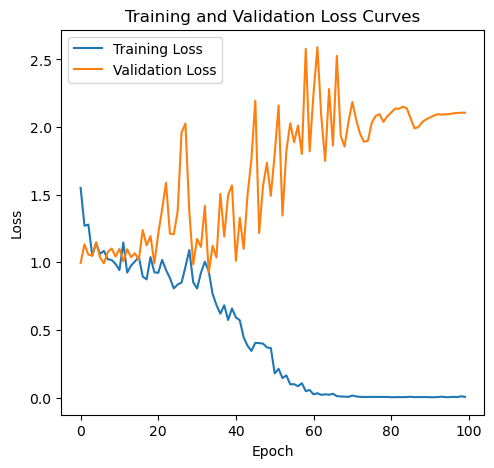

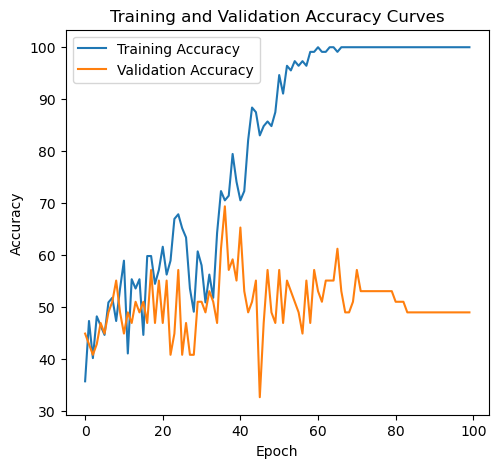

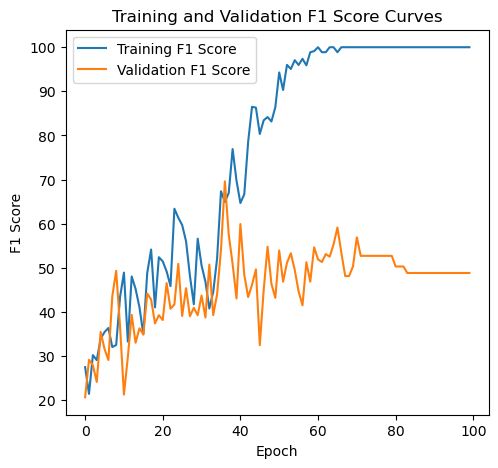

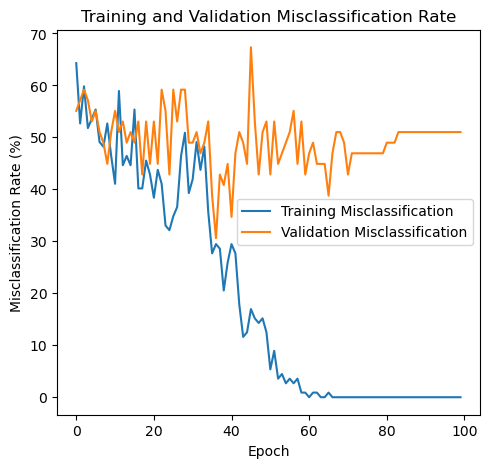

BatchSize:  16  / LR:  0.0001  / WeightDecay:  0.001  / Seed:  42
Best result: Epoch34,        
Train Loss: 0.9355, Train Acc: 51.79%, Train F1: 44.52% |        
Valid Loss: 0.9246, Valid Acc: 51.02%, Valid F1: 39.26%, Valid Misclass: 48.98%


In [72]:
def main():
    # Set seed for reproducibility
    seed_everything(config.seed)
    
    # Load the training data
    train_dataOrg = pd.read_csv(os.path.join(config.root, 'train.csv'))

    # Split the dataset into training and validation sets (70% train, 30% validation)
    train_data, val_data = train_test_split(train_dataOrg, train_size=0.7, test_size=0.3, random_state=config.seed)
            
    # Use the Vision Transformer transformations for ViT model
    train_dataset = ParkinsonsDataset(train_data, transforms=build_transform_ViT(True), mode="train")
    val_dataset = ParkinsonsDataset(val_data, transforms=build_transform_ViT(False), mode="valid")

    # DataLoader for training and validation sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)


    # Model Initialization: Vision Transformer (or SwinTransformer)
    print("Initializing Vision Transformer model...")

    # Initialize the Vision Transformer or SwinTransformer model
    model = SwinTransformerCustom(num_classes=config.num_classes)  # Using SwinTransformerCustom class

    # Move the model to the appropriate device
    model.to(config.device)

    # Define the loss function (CrossEntropy for classification)
    criterion = nn.CrossEntropyLoss().to(config.device)

    # TODO_5: Set the optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    # OneCycleLR learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        epochs=config.epochs,
        steps_per_epoch=len(train_loader),
        max_lr=config.lr,
        anneal_strategy='cos'
    )

    # Initialize metrics for tracking the best validation loss
    best_val_loss = float("inf")
    history = {
        "train": {"loss": [], "acc": [], "f1": [], "misclass": []},
        "valid": {"loss": [], "acc": [], "f1": [], "misclass": []}
    }
    best_epoch = 0

    # Training loop
    for epoch in range(config.epochs):
        # Train for one epoch
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        
        # Validate after each epoch
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)

        # Record metrics
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        # Print results for each epoch
        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        # Save the best model based on validation loss
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpointFiles/checkpointSwin.pth")
            best_epoch = epoch

    # Load the best checkpoint for evaluation
    best_ckpt = torch.load("checkpointFiles/checkpointSwin.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])

    # Plot the training and validation results
    printTrainresult(history, best_epoch)


if __name__ == "__main__":
    main()


In [73]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad(): 
        for image, age, gender in test_loader:
            image = image.to(device = device, dtype = torch.float)
            age = age.to(device)
            gender = gender.to(device)
            logits = model(image, age, gender)
            pred = torch.argmax(logits, dim = 1)
            preds.append(pred)

    preds = torch.cat(preds)
    
    # TODO_8: 因為輸出的 preds為 0,1,2，所以請調整成 1,2,3。
    preds = preds + 1
    
    return preds
    
    

In [74]:
seed_everything(config.seed)
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

# TODO_9: 填寫 test_dataset、test_loader、model 四個空格，記得 test_loader 的 shuffle = False。

# Creating the test dataset using the ParkinsonsDataset class
test_dataset = ParkinsonsDataset(test_data, mode="test", transforms=build_transform_ViT(is_train=False))

# DataLoader for the test dataset (shuffle is set to False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [75]:
# TODO_10: 將 .csv 取名。

# Initialize the model (VGGplus in this case, could be ResNetplus if you switch)
model3 = VisionTransformerCustom(num_classes=config.num_classes)

best_ckpt = torch.load(f"checkpointFiles/checkpointVit.pth", map_location=config.device)
model3.load_state_dict(best_ckpt["model"])


model3.to(config.device)

preds = testing(model3, test_loader, config.device)
# Create a DataFrame with predictions
submission_df3 = pd.DataFrame()  # Start with an empty DataFrame
submission_df3['ID'] = test_data['ID']

# Add the 'Stage' column with predictions
submission_df3['Stage'] = preds.cpu().numpy()  # Convert preds from GPU to CPU and then to NumPy

# Specify the path for the submission file
submission_file_path = os.path.join(config.root, 'submissionVit.csv')  # Ensure this points to the desired directory

# Save the DataFrame to a CSV file
submission_df3.to_csv(submission_file_path, index=False, header=True)  # Save without index and with header

print(f"Predictions saved to {submission_file_path}.")  # Print confirmation message


Predictions saved to ./hwk02_data\submissionVit.csv.


In [77]:
# TODO_10: 將 .csv 取名。

# Initialize the model (VGGplus in this case, could be ResNetplus if you switch)
model4 = SwinTransformerCustom(num_classes=config.num_classes)

best_ckpt = torch.load(f"checkpointFiles/checkpointSwin.pth", map_location=config.device)
model4.load_state_dict(best_ckpt["model"])


model4.to(config.device)

preds = testing(model4, test_loader, config.device)
# Create a DataFrame with predictions
submission_df3 = pd.DataFrame()  # Start with an empty DataFrame
submission_df3['ID'] = test_data['ID']

# Add the 'Stage' column with predictions
submission_df3['Stage'] = preds.cpu().numpy()  # Convert preds from GPU to CPU and then to NumPy

# Specify the path for the submission file
submission_file_path = os.path.join(config.root, 'submissionSwin.csv')  # Ensure this points to the desired directory

# Save the DataFrame to a CSV file
submission_df3.to_csv(submission_file_path, index=False, header=True)  # Save without index and with header

print(f"Predictions saved to {submission_file_path}.")  # Print confirmation message


Predictions saved to ./hwk02_data\submissionSwin.csv.
